In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils.engine as ue
import utils.visualizer as uv

In [ ]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

In [ ]:
plt.rcParams["animation.html"] = "jshtml"

In [ ]:
data = pd.read_csv('Validation/full_data.csv')

In [ ]:
with open("Validation/SHEBA_Data/12-levels.dat") as file:
    Z = [float(z.replace(' ', '')[:-1]) for z in file.readlines()]

## Инициализация профиля

In [ ]:
def get_init_from_data(data, dsigma_ice, dsigma_snow, snow_thickness_threshold=0.05, index=0):
    
    has_snow = (data.loc[index, 'hs_best'] - data.loc[index, 'hf_best']) >= snow_thickness_threshold
    
    filter_ice = (data.loc[index, 'hi_best'] < Z) & (Z < data.loc[index, 'hf_best'])
    filter_snow = (data.loc[index, 'hf_best'] < Z) & (Z < data.loc[index, 'hs_best'])

    Z_ice = np.concatenate((data.loc[index, ['hf_best']],
                            np.array(Z)[filter_ice],
                            data.loc[index, ['hi_best']]))

    Z_snow = np.concatenate((data.loc[index, ['hs_best']],
                            np.array(Z)[filter_snow],
                            data.loc[index, ['hf_best']]))

    T_ice = np.concatenate((data.loc[index, ['Tis_interp']],
                            data.loc[index, 'T_1':'T_50'][filter_ice],
                            data.loc[index, ['Tib_interp']]))

    T_snow = np.concatenate((data.loc[index, ['Tss_interp']],
                             data.loc[index, 'T_1':'T_50'][filter_snow],
                             data.loc[index, ['Tis_interp']]))

    sigma_ice_nodes = np.concatenate(([0.0], dsigma_ice.cumsum()))
    sigma_ice_centers = (sigma_ice_nodes[:-1] + sigma_ice_nodes[1:])/2
    Z_ice_new = Z_ice[-1] + sigma_ice_centers*(Z_ice[0] - Z_ice[-1])

    sigma_snow_nodes = np.concatenate(([0.0], dsigma_snow.cumsum()))
    sigma_snow_centers = (sigma_snow_nodes[:-1] + sigma_snow_nodes[1:])/2
    Z_snow_new = Z_snow[-1] + sigma_snow_centers*(Z_snow[0] - Z_snow[-1])

    T_ice_new = np.interp(Z_ice_new, Z_ice[::-1], T_ice[::-1])
    T_snow_new = np.interp(Z_snow_new, Z_snow[::-1], T_snow[::-1])
    
    return T_ice_new, T_snow_new, \
            data.loc[index, 'Tib_interp'], data.loc[index, 'Tis_interp'], \
            (data.loc[index, 'Tss_interp'] if has_snow else np.nan), \
            dsigma_ice*(data.loc[index, 'hf_best'] - data.loc[index, 'hi_best']), \
            (1.0 if has_snow else np.nan)*dsigma_snow \
            *(data.loc[index, 'hs_best'] - data.loc[index, 'hf_best'])

In [ ]:
dsigma_ice = np.full(20, 1.0/20)
dsigma_snow = np.full(5, 1.0/5)

In [ ]:
T_ice_init, T_snow_init, Toi_init, Tis_init, Tsa_init, \
dzi_init, dzs_init = get_init_from_data(data, dsigma_ice, dsigma_snow)

In [ ]:
e_s = lambda T: 6.11*np.exp(ue.c1_i*T/(T + ue.T0 - ue.c2_i))
q_surf = lambda T: 0.622*e_s(T)/(ue.P_surf - 0.378*e_s(T))

time_arr = ((data['jday'] - data.loc[0, 'jday'])*24*3600).values
albe = data['albe'].values
Tib_interp = data['Tib_interp'].values
tair = data['tair'].values
uair = data['uair'].values
qair = data['qair'].values
prec = data['prec_eff'].values
swdo = data['swdo'].values
lwdo = data['lwdo'].values
focn_pit = data['focn_pit'].values
Focn_y = data['Focn_y'].values


find_index_fast = lambda time_sec: np.searchsorted(time_arr, time_sec, side='right') - 1
albedo = lambda time: albe[find_index_fast(time)]
Toi = lambda time: Tib_interp[find_index_fast(time)]
T_a = lambda time: tair[find_index_fast(time)] - ue.T0
u_a = lambda time: uair[find_index_fast(time)]
q_a = lambda time: qair[find_index_fast(time)] * 1e-3
p = lambda time: prec[find_index_fast(time)] * ue.mmd_to_ms
F_sw = lambda time: swdo[find_index_fast(time)]
F_lw = lambda time: lwdo[find_index_fast(time)]
F_bolz = lambda T: -ue.sigma*(T + ue.T0)**4
F_sh = lambda T, time: ue.rho_a*ue.c_pa*ue.C_sh*u_a(time)*(T_a(time) - T)
F_lh = lambda T, time: ue.rho_a*ue.L_s0*ue.C_lh*u_a(time)*(q_a(time) - q_surf(T))
F_P = lambda T, time: p(time)*ue.rho_w*ue.c_pw*max(T_a(time) - T, 0)
F_atm = lambda T, time, i_0: ue.emissivity*(F_lw(time) + F_bolz(T)) \
                           + (1 - albedo(time))*(1 - i_0)*F_sw(time) \
                           + F_sh(T, time) + F_P(T, time) + F_lh(T, time) 

F_atm_ice = lambda T, time: F_atm(T, time, ue.i0_i)
F_atm_snow = lambda T, time: F_atm(T, time, ue.i0_s)
F_ocn = lambda T, time: Focn_y[find_index_fast(time)]

In [ ]:
inds_ib = np.searchsorted([-z for z in Z], -data['hi_best'])
inds_ib_40cm = np.searchsorted([-z for z in Z], -(data['hi_best']+0.4))
grad = lambda T_base, h1, h2, T0, T1: (-T_base*(h2**2 - h1**2) + T0*h2**2 - T1*h1**2)/(h1*h2*(h1-h2))
grad_lin = lambda T_base, h, T0: (T_base - T0)/h

In [ ]:
grads = np.array([grad(Toi, Z[ind_ib-1] - z_i, Z[ind_ib-2] - z_i, T[ind_ib-1], T[ind_ib-2]) \
                  for Toi, ind_ib, z_i, T \
                  in zip(data['Tib_interp'], inds_ib, data['hi_best'],
                         data.loc[:, 'T_1':'T_50'].itertuples(index=False))]
                 )

In [ ]:
grads_lin = np.array([grad_lin(Toi, Z[ind_ib-1] - z_i, T[ind_ib-1]) \
                      for Toi, ind_ib, z_i, T \
                      in zip(data['Tib_interp'], inds_ib, data['hi_best'],
                             data.loc[:, 'T_1':'T_50'].itertuples(index=False))]
                    )

In [ ]:
grads_lin_40cm = np.array([grad_lin(Toi, Z[ind_ib_40cm] - z_i, T[ind_ib_40cm]) \
                      for Toi, ind_ib_40cm, z_i, T \
                      in zip(data['Tib_interp'], inds_ib_40cm, data['hi_best'],
                             data.loc[:, 'T_1':'T_50'].itertuples(index=False))]
                    )

In [ ]:
Ls = np.array([ue.L_i(t, 4.0) for t in data.loc[:3999, 'Tib_interp']])


plt.figure(figsize = (15, 10))
plt.plot(data.loc[:3999, 'Fmib']/ue.rho_i/Ls, label='table')
plt.plot(np.array(([-ue.k_i(t, 4.0) for t in data.loc[:3999, 'Tib_interp']])*grads_lin_40cm[:4000] \
                  + data.loc[:3999, 'Focn_y'])/ue.rho_i/Ls, label='comp')
plt.plot((conds_k5g40 + data.loc[:3999, 'Focn_y'])/ue.rho_i/Ls, label='sim')
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize = (15, 10))
# data.loc[:3000, 'focn_pit'].plot()
plt.plot(np.array([ue.k_i(t, 4.0) for t in data.loc[:3000, 'Tib_interp']])*grads_lin_40cm[:3001], label='comp')
plt.plot(data.loc[:3000, 'Fcib'], label='table')
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize = (15, 10))
plt.plot([ue.k_i(t, 4.0) for t in data.loc[:3000, 'Tib_interp']])
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize = (15, 10))
plt.plot(np.array([ue.L_i(t, 4.0) for t in data['Tib_interp']]))
plt.grid()
plt.show()

In [ ]:
data['focn_pit'].plot(figsize=(15, 10), grid=True)

In [ ]:
%%time
sim_proc_k5g40_unter, conds_k5g40, Fs_k5g40 = ue.main_process \
(
    time_step=3600.0,
    time_end=4000*3600.0,
    N_pseudoiter=50,
    Ti_init=T_ice_init,
    Ts_init=T_snow_init,
    Tis_init=Tis_init,
    Tsa_init=Tsa_init,
    dzi_init=dzi_init,
    dzs_init=dzs_init,
    salinity=np.linspace(4.0, 1.0, len(dzi_init)),
    snow_thickness_threshold=0.01,
    Toi=Toi,
    Ta=T_a,
    p=p,
    F_atm_ice=F_atm_ice,
    F_atm_snow=F_atm_snow,
    F_sw=F_sw,
    F_ocn=F_ocn
)

In [ ]:
sheba_proc_short.get_length()

In [ ]:
data.columns

In [ ]:
data_proc = ue.process_from_data(Z,
                                 data.loc[:, 'T_1':'T_50'].values, 
                                 data['Tib_interp'].values, data['Tis_interp'].values,
                                 data['Tss_interp'].values,
                                 data['hi_best'].values, data['hf_best'].values,
                                 data['hs_best'].values,
                                 np.ones(20)/20.0, np.ones(5)/5.0,
                                 time_arr, ue.rho_i)

In [ ]:
uv.animate([data_proc], names=['data'], clip_end=1500, dpi=250)

In [ ]:
data_proc.ice_temp_history.min(axis=1) - sheba_proc.ice_temp_history[:-1].min(axis=1)

In [ ]:
def compare_profiles(process_data, process_simulation):
    assert process_data.get_length() == process_simulation.get_length(), \
           "Lenghts of input arrays ({}, {}) should be equal!".format(process_data.get_length(),
                                                                      process_simulation.get_length())
    
    assert process_data.get_nodes_num() == process_simulation.get_nodes_num(), \
           "Numbers of nodes for snow and ice for two processes ({}, {}) should be equal!"\
           .format(process_data.get_nodes_num(), process_simulation.get_nodes_num())
    
    plt.figure(figsize=(35, 50))
    
    plt.subplot(5, 2, 1)
    plt.title("Min temperarure error for ice")
    plt.plot(process_simulation.timeline,
             process_data.ice_temp_history.min(axis=1) - process_simulation.ice_temp_history.min(axis=1))
    plt.grid()
    
    plt.subplot(5, 2, 2)
    plt.title("Min temperarure error for snow")
    plt.plot(process_simulation.timeline,
             process_data.snow_temp_history.min(axis=1) - process_simulation.snow_temp_history.min(axis=1))
    plt.grid()
    
    plt.subplot(5, 2, 3)
    plt.title("Max temperarure error for ice")
    plt.plot(process_simulation.timeline,
             process_data.ice_temp_history.max(axis=1) - process_simulation.ice_temp_history.max(axis=1))
    plt.grid()
    
    plt.subplot(5, 2, 4)
    plt.title("Max temperarure error for snow")
    plt.plot(process_simulation.timeline,
             process_data.snow_temp_history.max(axis=1) - process_simulation.snow_temp_history.max(axis=1))
    plt.grid()
    
    plt.subplot(5, 2, 5)
    plt.title("Max temperature difference error for ice")
    plt.plot(process_simulation.timeline,
             abs(process_data.ice_temp_history - process_simulation.ice_temp_history).max(axis=1))
    plt.grid()
    
    plt.subplot(5, 2, 6)
    plt.title("Max temperarure difference error for snow")
    plt.plot(process_simulation.timeline,
             abs(process_data.snow_temp_history - process_simulation.snow_temp_history).max(axis=1))
    plt.grid()
    
    plt.subplot(5, 2, 7)
    plt.title("Avg temperature difference error for ice")
    plt.plot(process_simulation.timeline,
             np.sqrt(((process_data.ice_temp_history - process_simulation.ice_temp_history)**2).mean(axis=1)))
    plt.grid()
    
    plt.subplot(5, 2, 8)
    plt.title("Avg temperarure difference error for snow")
    plt.plot(process_simulation.timeline,
             np.sqrt(((process_data.snow_temp_history - process_simulation.snow_temp_history)**2).mean(axis=1)))
    plt.grid()
    
    plt.subplot(5, 2, 9)
    plt.title("Thickness error for ice")
    plt.plot(process_simulation.timeline,
             process_data.ice_dz_history.sum(axis=1) - process_simulation.ice_dz_history.sum(axis=1))
    plt.grid()
    
    plt.subplot(5, 2, 10)
    plt.title("Thickness error for snow")
    plt.plot(process_simulation.timeline,
             process_data.snow_dz_history.sum(axis=1) - process_simulation.snow_dz_history.sum(axis=1))
    plt.grid()
    
    plt.show()

In [ ]:
compare_profiles(data_proc, sim_proc)

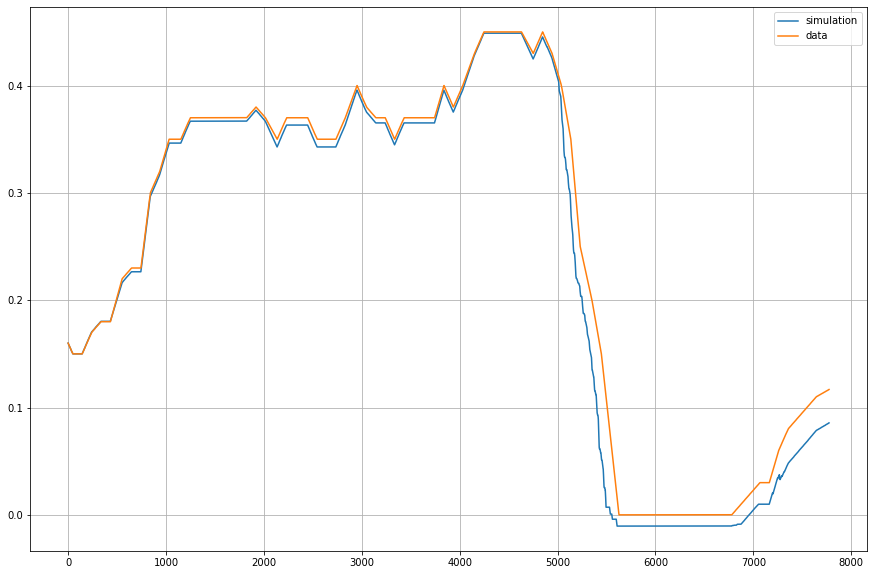

In [375]:
plt.figure(figsize=(15, 10))
plt.plot(sim_proc.snow_dz_history.sum(axis=1), label='simulation')
plt.plot(data_proc.snow_dz_history.sum(axis=1), label='data')
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(sim_proc.ice_dz_history.sum(axis=1), label='simulation')
plt.plot(data_proc.ice_dz_history.sum(axis=1), label='data')
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(sim_proc_k5.snow_dz_history.sum(axis=1), label='simulation')
plt.plot(data_proc.snow_dz_history.sum(axis=1), label='data')
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(sim_proc_k5.ice_dz_history.sum(axis=1), label='simulation')
plt.plot(data_proc.ice_dz_history.sum(axis=1), label='data')
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(sim_proc_k5_fix.ice_dz_history.sum(axis=1), label='simulation')
plt.plot(data_proc.ice_dz_history.sum(axis=1), label='data')
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(sim_proc_k5_unter.ice_dz_history.sum(axis=1), label='simulation')
plt.plot(data_proc.ice_dz_history.sum(axis=1), label='data')
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(sim_proc_k5F_unter.ice_dz_history.sum(axis=1), label='simulation')
plt.plot(data_proc.ice_dz_history.sum(axis=1), label='data')
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(sim_proc_k5g40_unter.ice_dz_history.sum(axis=1), label='simulation')
plt.plot(data_proc.ice_dz_history.sum(axis=1), label='data')
plt.legend()
plt.grid()
plt.show()